<p style="text-align: center;font-size: 60px;">Stars</p>
<br\><br\>
PLAsTiCC Astronomical Classification<br/>
https://www.kaggle.com/c/PLAsTiCC-2018
<br\><br\>

[Kernel]<br\>
* Kernel Strategies for Flux Time Series Preprocessing<br/>
https://www.kaggle.com/mithrillion/strategies-for-flux-time-series-preprocessing

* Light Gradient Boosting Machine<br/>
https://www.kaggle.com/iprapas/ideas-from-kernels-and-discussion-lb-1-135
<br\>

* Kernel using Neural Network<br/>
https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import gc

<p style="text-align: center;font-size: 40px;">Part 1. Load Metadata</p>
<br\>

# 1. Load Training Metatata

In [24]:
# tm: train_metadata
TM = pd.read_csv('training_set_metadata.csv')
print("Size:", TM.shape[0])
TM.sort_values(by=['object_id'], ascending=True).head(3)

Size: 7848


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42


# 2. Modify column property and Remove unused column
* Change datatype into categorical data for column['DDF', 'target']
* Remove unused cloumn['hostgal_specz']

In [25]:
TM['ddf'] = TM['ddf'].astype('category')
TM['target'] = TM['target'].astype('category')
TM.drop(['hostgal_specz'], axis=1, inplace=True)
TM.sort_values(by=['object_id'], ascending=True).head(3)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,42


<p style="text-align: center;font-size: 40px;">Part 2. Load Time series data</p>
<br\>

# 1. Load Training Time Series Data

In [26]:
# ts: train_series_data
TS = pd.read_csv('training_set.csv')
print("Size:", TS.shape[0])
TS.sort_values(by=['object_id'], ascending=True).head(10)

Size: 1421705


,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
239,615,60493.2639,4,-406.733521,3.772714,1
238,615,60493.2527,3,-530.644592,3.672556,1
237,615,60493.2450,1,-1031.102905,6.378702,1
236,615,60493.2372,2,-680.489441,4.065931,1
235,615,60490.3024,5,-395.406128,8.139952,1
234,615,60490.2913,4,-371.286377,3.985296,1
233,615,60490.2802,3,-405.614258,3.513195,1
232,615,60490.2725,1,-624.518799,4.704853,1
240,615,60493.2750,5,-358.876160,7.310321,1


# 2. Aggregation and Merging

## 2-1 Generate statistical data based on (object_id, passband)

In [27]:
features = TS.copy()
gc.enable()

# Generate new features
features['flux_ratio_sq'] = np.power(features['flux'] / features['flux_err'], 2.0)
features['flux_by_flux_ratio_sq'] = features['flux'] * features['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

# Execute aggregation and rename columns
agg_features = features.groupby(['object_id','passband']).agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_features.columns = new_columns

# Generate new features 
agg_features['mjd_diff'] = agg_features['mjd_max'] - agg_features['mjd_min']
agg_features['flux_diff'] = agg_features['flux_max'] - agg_features['flux_min']
agg_features['flux_dif2'] = (agg_features['flux_max'] - agg_features['flux_min']) / agg_features['flux_mean']
agg_features['flux_w_mean'] = agg_features['flux_by_flux_ratio_sq_sum'] / agg_features['flux_ratio_sq_sum']
agg_features['flux_dif3'] = (agg_features['flux_max'] - agg_features['flux_min']) / agg_features['flux_w_mean']

# Remove usless columns
del agg_features['mjd_max'], agg_features['mjd_min']
gc.collect()

300

In [28]:
# Update column names

updated_agg = agg_features.unstack()

updated_columns = []
for column in list(agg_features):
    for i in range(0,6):
        updated_columns.append('passband' + str(i) + '_' + column)

updated_agg.columns = updated_columns
updated_agg.reset_index(inplace=True)
updated_agg.head(3)

,object_id,passband0_mjd_size,passband1_mjd_size,passband2_mjd_size,passband3_mjd_size,passband4_mjd_size,passband5_mjd_size,passband0_flux_min,passband1_flux_min,passband2_flux_min,...,passband2_flux_w_mean,passband3_flux_w_mean,passband4_flux_w_mean,passband5_flux_w_mean,passband0_flux_dif3,passband1_flux_dif3,passband2_flux_dif3,passband3_flux_dif3,passband4_flux_dif3,passband5_flux_dif3
0,615,63,58,58,58,58,57,-116.913223,-1100.440063,-681.858887,...,-214.947803,-232.265606,-111.843477,-126.326197,-12.552744,-2.790325,-6.019338,-4.203729,-7.189854,-6.340753
1,713,70,56,56,56,56,56,-14.735178,-11.715749,-10.067919,...,-3.821839,-4.894058,-4.179287,-4.904860,-4.110659,-4.106502,-5.389280,-4.847697,-5.291509,-5.908843
2,730,72,52,52,52,51,51,-3.459960,-3.393080,-2.848838,...,16.797566,26.385068,33.303042,32.979248,216.222790,26.022646,1.419465,1.478408,1.411171,2.015506


In [29]:
# Check and clean null data

print('shape:', updated_agg.shape)
problemed_data = updated_agg[updated_agg.isnull().any(axis=1)]
print('number of rows having any null value', problemed_data.shape[0])
updated_agg.fillna(0, inplace=True)
problemed_data = updated_agg[updated_agg.isnull().any(axis=1)]
print('number of rows having any null value after fill zero', problemed_data.shape[0])

shape: (7848, 139)
number of rows having any null value 1
number of rows having any null value after fill zero 0


## 2-2 Merge Metadata and Time Series Data AND "Save it"

In [30]:
all_features = pd.merge(updated_agg, TM, left_on='object_id', right_on='object_id', how='left')
del all_features['distmod']

all_features.to_csv('training_aggregated_data.csv', index=False)

## 2-3 Read data from disk

In [31]:
all_features = pd.read_csv('training_aggregated_data.csv')
all_features.head(3)

,object_id,passband0_mjd_size,passband1_mjd_size,passband2_mjd_size,passband3_mjd_size,passband4_mjd_size,passband5_mjd_size,passband0_flux_min,passband1_flux_min,passband2_flux_min,...,passband5_flux_dif3,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,mwebv,target
0,615,63,58,58,58,58,57,-116.913223,-1100.440063,-681.858887,...,-6.340753,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.017,92
1,713,70,56,56,56,56,56,-14.735178,-11.715749,-10.067919,...,-5.908843,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,0.007,88
2,730,72,52,52,52,51,51,-3.459960,-3.393080,-2.848838,...,2.015506,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,0.021,42


<p style="text-align: center;font-size: 40px;">Part 3. <br\><br\>Split data into training set and test set</p>
<br\>

# 1. Seperate data into train and test

In [32]:
from sklearn.model_selection import StratifiedShuffleSplit

In [33]:
# https://stackoverflow.com/questions/51852551/key-error-not-in-index-while-cross-validation
# add iloc while setting train and test by index number
y = all_features[['target']]
X = all_features.copy()
del X['target'], X['object_id']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [6087 1980 1968 ... 1939 3209 4710] TEST: [ 749 3164  421 ... 6442  311 3179]


<p style="text-align: center;font-size: 40px;">Part 4. <br\><br\> Feature Selection</p>
<br\>
Sklearn Feature Selection<br\>
https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel

# Feature normalization

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

# 1. Feature selection with different methods from Sklearn

## 1.1 Removing features with low variance

In [36]:
from sklearn.feature_selection import VarianceThreshold

In [37]:
sel = VarianceThreshold(.9 * (1 - .9))
X_new1 = sel.fit_transform(X_train)
X_new1.shape

(5493, 4)

## 1.2 Univariate feature selection

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [39]:
X_new2 = SelectKBest(chi2, k=10).fit_transform(X_train, y_train)
X_new2.shape

(5493, 10)

## 1.3 Feature selection using different model with SelectFromModel

In [40]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [41]:
lsvc = LinearSVC(C=0.01, class_weight='balanced', penalty="l1", dual=False).fit(X_train, y_train)
model3 = SelectFromModel(lsvc, prefit=True)
X_new3 = model3.transform(X_train)
X_new3.shape

(5493, 32)

In [42]:
lr = LogisticRegression(C=0.1, class_weight='balanced', random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)
model4 = SelectFromModel(lr, prefit=True)
X_new4 = model4.transform(X_train)
X_new4.shape

(5493, 41)

In [43]:
tree = ExtraTreesClassifier(n_estimators=50).fit(X_train, y_train)
tree.feature_importances_  
model5 = SelectFromModel(tree, prefit=True)
X_new5 = model5.transform(X_train)
X_new5.shape   

(5493, 44)

Different dataset with different feature selection methods:<br\>
* Removing features with low variance: X_new1 (4)
* Univariate feature selection(SelectKBest): X_new2 (10)
* Feature selection using SelectFromModel
  1. LinearSVC: X_new3 (32)
  2. LogisticRegression: X_new4 (41)
  3. ExtraTreesClassifier: X_new5 (45)

# 2. Feature Decomposition with different methods from Sklearn

In [44]:
from sklearn.decomposition import KernelPCA
model6 = KernelPCA(n_components=10).fit(X_train, y_train)
X_new6 = model6.transform(X_train)
X_new6.shape

(5493, 10)

In [45]:
from sklearn.decomposition import KernelPCA
model7 = KernelPCA(n_components=20).fit(X_train, y_train)
X_new7 = model7.transform(X_train)
X_new7.shape

(5493, 20)

In [46]:
from sklearn.decomposition import KernelPCA
model8 = KernelPCA(n_components=30).fit(X_train, y_train)
X_new8 = model8.transform(X_train)
X_new8.shape

(5493, 30)

<p style="text-align: center;font-size: 40px;">Part 5. <br\><br\> Build classifiers with Cross Validation<br\><br\></p>
<br\>

## All features with Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='lbfgs', class_weight='balanced', multi_class='multinomial', random_state=0).fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.4804296377207355
0.370276008492569


## PCA - poly kernel with all possible features and Logistic Regression

time consuming - don't execute

In [48]:
# model = KernelPCA(kernel='poly').fit(X_train, y_train)
# X = model.transform(X_train)
# y = y_train
# X_test_tmp = model.transform(X_test)
# clf = LogisticRegressionCV(cv=5, solver='lbfgs', class_weight='balanced', multi_class='multinomial', random_state=0).fit(X, y)

In [49]:
# print(clf.score(X, y_train))
# print(clf.score(X_test_tmp, y_test))

## PCA-linear kernel(different number of features) with Logistic Regression

In [50]:
comps = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 130, 160, 190, 210]
models = []
clfs = []
scores_train = []
scores_test = []

for comp in comps:
    print('current comp:', comp)
    model = KernelPCA(n_components=comp).fit(X_train, y_train)
    X = model.transform(X_train)
    y = y_train
    X_test_tmp = model.transform(X_test)
    clf = LogisticRegressionCV(cv=5, solver='lbfgs', class_weight='balanced', multi_class='multinomial', random_state=0).fit(X, y)
    
    models.append(model)
    clfs.append(clf)
    scores_train.append(clf.score(X, y_train))
    scores_test.append(clf.score(X_test_tmp, y_test))

current comp: 10
current comp: 20
current comp: 30
current comp: 40
current comp: 50
current comp: 60
current comp: 70
current comp: 80
current comp: 90
current comp: 100
current comp: 130
current comp: 160
current comp: 190
current comp: 210


In [51]:
scores_train

[0.3790278536318951,
 0.5059166211541962,
 0.5392317494993628,
 0.5596213362461314,
 0.5709084289095212,
 0.5871108683779356,
 0.5923903149462952,
 0.5960313125796468,
 0.6013107591480066,
 0.6034953577280174,
 0.601128709266339,
 0.6042235572546878,
 0.6038594574913526,
 0.6018569087930092]

In [52]:
scores_test

[0.35966029723991505,
 0.4607218683651805,
 0.36348195329087046,
 0.22123142250530786,
 0.15159235668789808,
 0.16772823779193205,
 0.17367303609341825,
 0.14522292993630573,
 0.17367303609341825,
 0.16772823779193205,
 0.1643312101910828,
 0.16093418259023354,
 0.16050955414012738,
 0.15966029723991507]

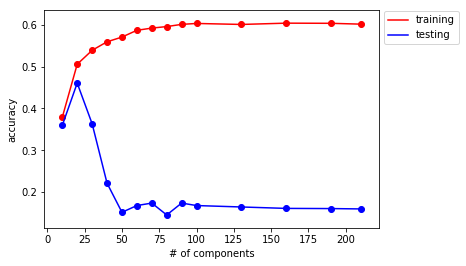

In [53]:
plt.plot(comps, scores_train, c = 'red')
plt.plot(comps, scores_test, c = 'blue')
plt.scatter(comps, scores_train, c = 'red')
plt.scatter(comps, scores_test, c = 'blue')

plt.xlabel('# of components')
plt.ylabel('accuracy')

plt.legend(('training', 'testing'), loc='middle right', bbox_to_anchor=(1, 1.02))

## PCA-poly kernel(different number of features) with Logistic Regression

current comp: 2
current comp: 3
current comp: 4
current comp: 5
current comp: 6
current comp: 7
current comp: 8
current comp: 9
current comp: 10
current comp: 11
current comp: 12
current comp: 13
current comp: 14
current comp: 15
current comp: 16
current comp: 17
current comp: 18
current comp: 19
current comp: 20


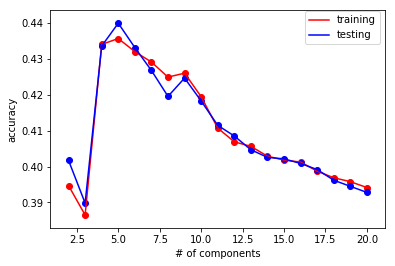

In [54]:
from sklearn.svm import SVC
clf = SVC(random_state=0)

comps = [i for i in range(2,21)]
scores_train = []
scores_test = []

for comp in comps:
    print('current comp:', comp)
    model = KernelPCA(n_components=comp, kernel='poly').fit(X_train, y_train)
    X = model.transform(X_train)
    y = y_train
    X_test_tmp = model.transform(X_test)
    
    clf.fit(X, y)
    scores_train.append(clf.score(X, y_train))
    scores_test.append(clf.score(X_test_tmp, y_test))
    
    
plt.plot(comps, scores_train, c = 'red')
plt.plot(comps, scores_test, c = 'blue')
plt.scatter(comps, scores_train, c = 'red')
plt.scatter(comps, scores_test, c = 'blue')

plt.xlabel('# of components')
plt.ylabel('accuracy')

plt.legend(('training', 'testing'), loc='middle right', bbox_to_anchor=(1, 1.02))

## RandomForest

current feature: 5
current feature: 10
current feature: 15
current feature: 20
current feature: 25
current feature: 30
current feature: 35
current feature: 40


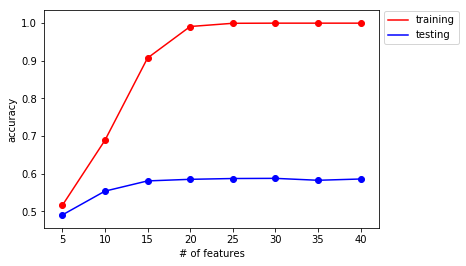

In [55]:
from sklearn.ensemble import RandomForestClassifier

features = [5, 10, 15, 20, 25, 30, 35, 40]
scores_train = []
scores_test = []

for feature in features:
    print('current feature:', feature)
    clf = RandomForestClassifier(n_estimators=100, max_depth=feature, random_state=0)
    clf.fit(X, y)
    scores_train.append(clf.score(X, y_train))
    scores_test.append(clf.score(X_test_tmp, y_test))
    
    
plt.plot(features, scores_train, c = 'red')
plt.plot(features, scores_test, c = 'blue')
plt.scatter(features, scores_train, c = 'red')
plt.scatter(features, scores_test, c = 'blue')

plt.xlabel('# of features')
plt.ylabel('accuracy')

plt.legend(('training', 'testing'), loc='middle right', bbox_to_anchor=(1, 1.02))

In [56]:
scores_train

[0.5157473147642454,
 0.6886947023484434,
 0.9073366102312034,
 0.9910795557982888,
 0.9996359002366648,
 1.0,
 1.0,
 1.0]

In [57]:
scores_test

[0.49044585987261147,
 0.5537154989384289,
 0.5808917197452229,
 0.5851380042462845,
 0.5872611464968153,
 0.5876857749469214,
 0.5825902335456475,
 0.5859872611464968]

## Gradient boosting

current feature: 5
current feature: 10
current feature: 15
current feature: 20
current feature: 25
current feature: 30
current feature: 35
current feature: 40


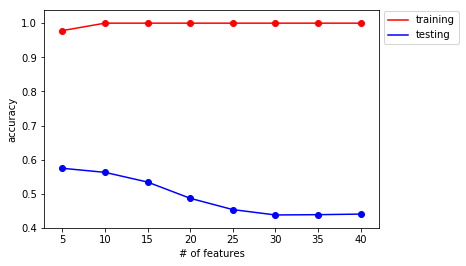

In [62]:
from sklearn.ensemble import RandomForestClassifier

features = [5, 10, 15, 20, 25, 30, 35, 40]
scores_train = []
scores_test = []

for feature in features:
    print('current feature:', feature)
    clf = GradientBoostingClassifier(n_estimators=100, max_depth=feature, random_state=0)
    #clf = RandomForestClassifier(n_estimators=100, max_depth=feature, random_state=0)
    clf.fit(X, y)
    scores_train.append(clf.score(X, y_train))
    scores_test.append(clf.score(X_test_tmp, y_test))
    
    
plt.plot(features, scores_train, c = 'red')
plt.plot(features, scores_test, c = 'blue')
plt.scatter(features, scores_train, c = 'red')
plt.scatter(features, scores_test, c = 'blue')

plt.xlabel('# of features')
plt.ylabel('accuracy')

plt.legend(('training', 'testing'), loc='middle right', bbox_to_anchor=(1, 1.02))

In [63]:
scores_train

[0.9781540141998908, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [64]:
scores_test

[0.5749469214437367,
 0.5630573248407643,
 0.5346072186836518,
 0.4870488322717622,
 0.45392781316348196,
 0.43821656050955415,
 0.43906581740976647,
 0.4407643312101911]

## Feature transformations with ensembles of trees (Don't try this - needs editing)

In [59]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline


In [61]:
# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=10,
                          random_state=0)

rt_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

ValueError: multiclass format is not supported

In [ ]:
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder(categories='auto')
rf_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder(categories='auto')
grd_lm = LogisticRegression(solver='lbfgs', max_iter=1000)
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)



In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

## RandomForest with feature decomposition (Don't run this - needs editing)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

features = [5, 10, 15, 20, 25, 30, 35, 40]
scores_train = []
scores_test = []

for feature in features:
    print('current feature:', feature)
    clf = RandomForestClassifier(n_estimators=100, max_depth=feature, random_state=0)
    clf.fit(X, y)
    scores_train.append(clf.score(X, y_train))
    scores_test.append(clf.score(X_test_tmp, y_test))
    
    
plt.plot(features, scores_train, c = 'red')
plt.plot(features, scores_test, c = 'blue')
plt.scatter(features, scores_train, c = 'red')
plt.scatter(features, scores_test, c = 'blue')

plt.xlabel('# of features')
plt.ylabel('accuracy')

plt.legend(('training', 'testing'), loc='middle right', bbox_to_anchor=(1, 1.02))

## Random Forest with Grid Search 

In [65]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [66]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20)

In [67]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [68]:
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


In [69]:
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


RandomizedSearchCV took 55.60 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.588 (std: 0.012)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.584 (std: 0.010)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.583 (std: 0.011)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 4}



In [70]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

GridSearchCV took 311.93 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.595 (std: 0.007)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.591 (std: 0.009)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.591 (std: 0.006)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}

